In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from xgboost import XGBRegressor

## Data preparing

In [2]:
df = pd.read_csv("retail_store_inventory_adjusted_int.csv")
df['Date']= pd.to_datetime(df['Date'])
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales.head()

,Date,Units Sold
0,2022-01-01,10149
1,2022-01-02,10055
2,2022-01-03,10380
3,2022-01-04,10735
4,2022-01-05,10294


# LSTM

<Axes: >

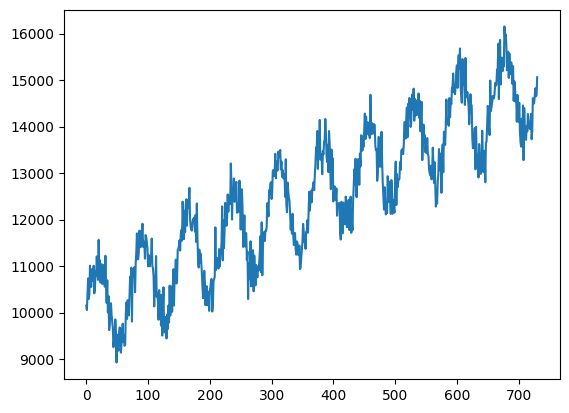

In [3]:
daily_sales["Units Sold"].plot()

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_sales[['Units Sold']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30     
X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape

((560, 30, 1), (141, 30, 1))

In [5]:
scaled_data.shape

(731, 1)

Epoch 1/200


c:\Users\ali_e\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0761 - val_loss: 0.0153
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

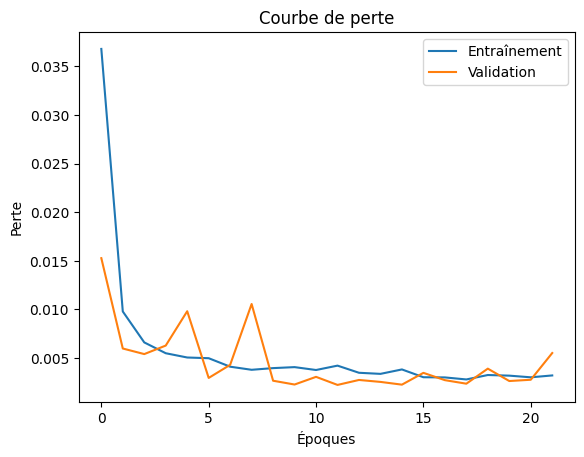

In [6]:
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1,callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


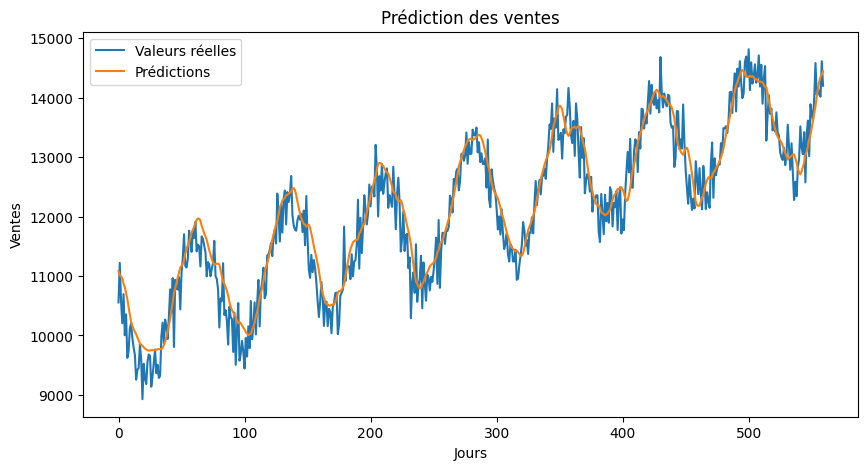

In [7]:
predictions = model.predict(X_train)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_train)

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Valeurs réelles')
plt.plot(predictions_rescaled, label='Prédictions')
plt.title('Prédiction des ventes')
plt.xlabel('Jours')
plt.ylabel('Ventes')
plt.legend()
plt.show()


In [8]:
X_test.shape

(141, 30, 1)

In [9]:
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

print(f"MSE (LSTM) : {mse:.2f}")
print(f"MAE (LSTM) : {mae:.2f}")
print(f"RMSE (LSTM) : {rmse:.2f}")

MSE (LSTM) : 135644.14
MAE (LSTM) : 292.84
RMSE (LSTM) : 368.30


# XGBOOST

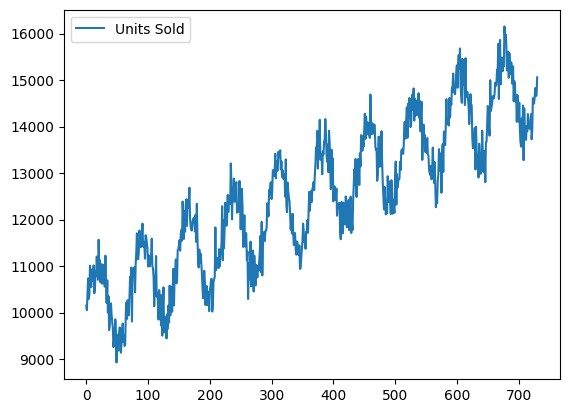

In [2]:
daily_sales2 = pd.read_csv("daily_sales_.csv")
daily_sales2.plot()
daily_sales2.set_index("Date", inplace=True)
daily_sales2.index = pd.to_datetime(daily_sales2.index)

In [3]:
split = int(0.8 * len(daily_sales2))
train = daily_sales2[:split]
test = daily_sales2[split:]

In [4]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

daily_sales2 = create_features(daily_sales2)


In [5]:
daily_sales2.sample(5)

,Units Sold,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2022-11-20,13295,6,4,11,2022,324,20,46
2023-06-22,14348,3,2,6,2023,173,22,25
2023-04-12,14044,2,2,4,2023,102,12,15
2023-01-25,13371,2,1,1,2023,25,25,4
2022-11-30,11699,2,4,11,2022,334,30,48


In [6]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'month', 'year', 'dayofmonth', "weekofyear"]
TARGET = 'Units Sold'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [7]:
reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:11944.88483	validation_1-rmse:14379.07161
[100]	validation_0-rmse:4447.28313	validation_1-rmse:6115.06647
[200]	validation_0-rmse:1733.69433	validation_1-rmse:3021.99863
[300]	validation_0-rmse:780.88354	validation_1-rmse:2003.62986
[400]	validation_0-rmse:476.90687	validation_1-rmse:1547.54896


c:\Users\ali_e\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:27:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:380.35358	validation_1-rmse:1267.48113
[600]	validation_0-rmse:343.43413	validation_1-rmse:1104.59645
[700]	validation_0-rmse:320.18142	validation_1-rmse:1011.78631
[800]	validation_0-rmse:301.59600	validation_1-rmse:937.02213
[900]	validation_0-rmse:288.15692	validation_1-rmse:866.13950
[1000]	validation_0-rmse:277.95948	validation_1-rmse:812.57741
[1100]	validation_0-rmse:269.76668	validation_1-rmse:782.48057
[1200]	validation_0-rmse:262.52115	validation_1-rmse:763.46506
[1300]	validation_0-rmse:255.89913	validation_1-rmse:748.63401
[1400]	validation_0-rmse:250.48498	validation_1-rmse:736.40013
[1500]	validation_0-rmse:245.98135	validation_1-rmse:727.44608
[1600]	validation_0-rmse:242.31177	validation_1-rmse:721.53799
[1700]	validation_0-rmse:238.61655	validation_1-rmse:716.56331
[1800]	validation_0-rmse:235.20954	validation_1-rmse:712.38545
[1900]	validation_0-rmse:232.19579	validation_1-rmse:708.28750
[2000]	validation_0-rmse:229.32320	validation_1-rmse:703.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

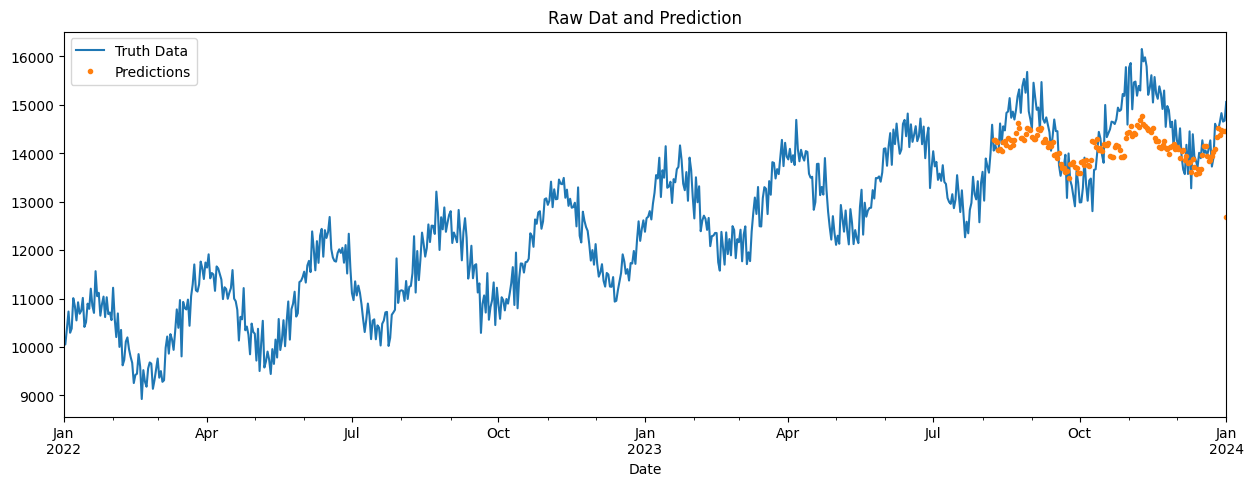

In [8]:
test['prediction'] = reg.predict(X_test)
df = daily_sales2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Units Sold']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


In [9]:
test.shape

(147, 9)

In [13]:
RMSE_score = np.sqrt(mean_squared_error(test['Units Sold'], test['prediction']))
MAE_score = mean_absolute_error(test['Units Sold'], test['prediction'])
print(f'MAE Score on Test set: {MAE_score:0.2f}')
print(f'RMSE Score on Test set: {RMSE_score:0.2f}')

MAE Score on Test set: 556.73
RMSE Score on Test set: 687.68


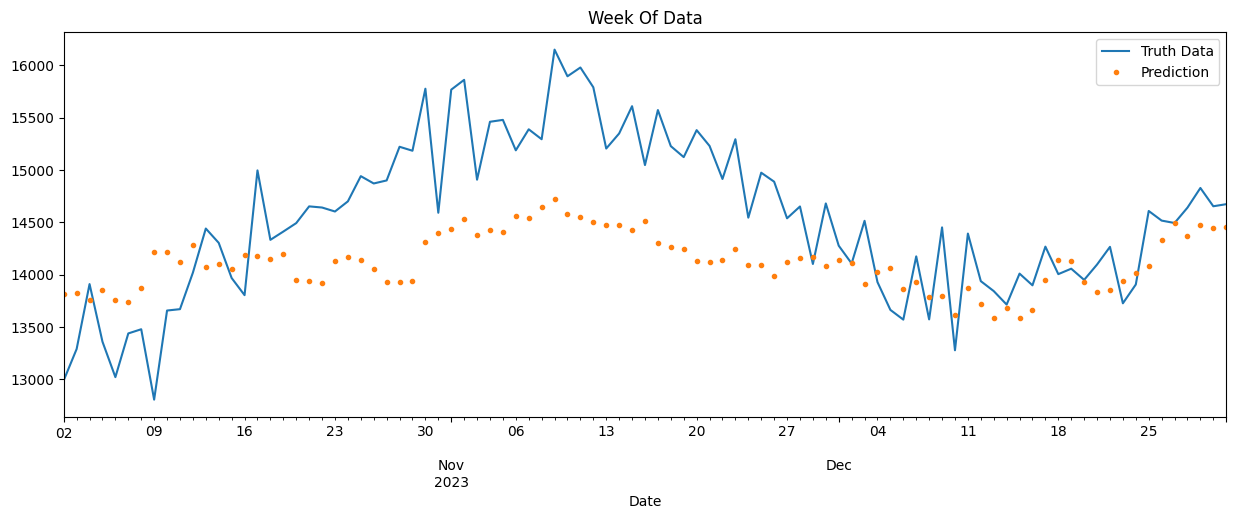

In [48]:
ax = daily_sales2.loc[(daily_sales2.index > '10-01-2023') & (daily_sales2.index < '01-01-2024')]['Units Sold'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(daily_sales2.index > '10-01-2023') & (daily_sales2.index < '01-01-2024')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1094.043, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1245.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1195.013, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1207.907, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1244.358, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1185.132, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1085.651, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1092.901, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

B

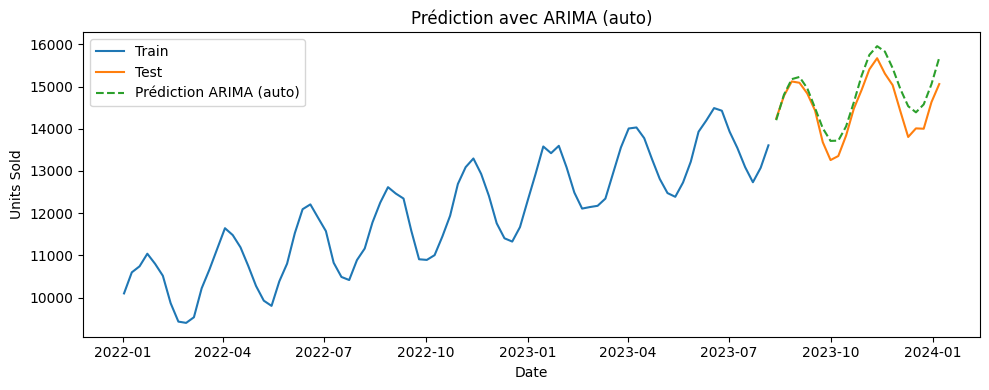

In [19]:
df = pd.read_csv('daily_sales_.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

weekly_data = df['Units Sold'].resample('W').mean()

train_size = int(len(weekly_data) * 0.8)
train, test = weekly_data[:train_size], weekly_data[train_size:]

model_auto = auto_arima(train, seasonal=False, stepwise=True, trace=True,
                        error_action='ignore', suppress_warnings=True, max_p=5, max_q=5, max_d=2)

print("Meilleur modèle trouvé :", model_auto.summary())

forecast = model_auto.predict(n_periods=len(test))

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Prédiction ARIMA (auto)', linestyle='--')
plt.title("Prédiction avec ARIMA (auto)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

